In [ ]:
pip install node2vec

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import random
from IPython.display import Image
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
nx.__version__

'2.8.8'

<h1> GRAPH COMPUTATION </h1>

<p> First thing to do is to retreive the articles from the 4 datasets. In addition to that, for each row of the dataset we add a flag called 'verdict', which is equal to 0 if the news is fake, 1 if it's legit. This will be helpful later for the supervised classification task, since it's the label used to train the models. </p>

In [3]:
politic_fake = pd.read_csv("fakeNewsDataset/politifact_fake.csv")

politic_fake['verdict'] = np.zeros(politic_fake.shape[0], dtype='int32')

display(politic_fake)

,id,news_url,title,tweet_ids,verdict
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...
427,politifact14944,http://thehill.com/homenews/senate/369928-who-...,Who is affected by the government shutdown?,954602090462146560\t954602093171609600\t954650...,0
428,politifact14071,https://web.archive.org/web/20170322070001/htt...,Lindsey Graham Threatens To Convert To Democra...,740351669834244096\t740391312277573632\t740474...,0
429,politifact13577,http://archive.is/DQqCx,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,810939651900907520\t814738996706164737\t814917...,0
430,politifact13560,politicono.com/palin-calls-boycott-mall-americ...,Sarah Palin Calls To Boycott Mall Of America B...,805216591424212993\t805222830023540736\t805223...,0


In [4]:
gossip_fake = pd.read_csv("fakeNewsDataset/gossipcop_fake.csv")

gossip_fake['verdict'] = np.zeros(gossip_fake.shape[0], dtype='int32')

display(gossip_fake)

,id,news_url,title,tweet_ids,verdict
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0
...,...,...,...,...,...
5318,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080,0
5319,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...,0
5320,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...,0
5321,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...,0


In [5]:
politic_real = pd.read_csv("fakeNewsDataset/politifact_real.csv")

politic_real['verdict'] = np.ones(politic_real.shape[0], dtype='int32')

display(politic_real)

,id,news_url,title,tweet_ids,verdict
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,1
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,1
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,1
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,1
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,1
...,...,...,...,...,...
619,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
620,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
621,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
622,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1


In [6]:
gossip_real = pd.read_csv("fakeNewsDataset/gossipcop_real.csv")

gossip_real['verdict'] = np.ones(gossip_real.shape[0], dtype='int32')

display(gossip_real)

,id,news_url,title,tweet_ids,verdict
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,1
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,1
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,1
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,1
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,1
...,...,...,...,...,...
16812,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1
16813,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1
16814,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1
16815,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1


<p> All the separate dataset are now merged into a single one. To do so, we can simply concatenate all 4 dataFrames into a single one. For now, since we are computing the corresponding graph of the entire dataset, there's no need to care about the order of concatenation and how the rows are sorted. </p>

In [7]:
dataset = pd.DataFrame()
dataset = pd.concat([politic_fake, politic_real, gossip_fake, gossip_real], ignore_index=True)

display(dataset)

,id,news_url,title,tweet_ids,verdict
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...
23191,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1
23192,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1
23193,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1
23194,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1


<p> Each article (identified using its unique id) has a list of tweets which have mentioned it. This list contains the tweets ids, separated by a tabs (\t). The problem is that it is stored inside the dataFrame as a list of single characters, meaning that trying to split it as it is would return every single digit (and tabs) as unique elements (e.g 937349434668498944 would be stored in the list obtained from split as ['9', '3', '7', '3','4','9','4','3','4','6','6','8','4','9','8','9','4','4']). To solve the problem, we can use the ''.join() method to create a single string (no character passed in "" so that no additional character will be added between the digits) and after that .split() so that the string is correctly split according to the position of the tabs</p>

In [8]:
articles_dict = {}

# iterate through all articles in the dataset
for i in range(len(dataset['id'])):
    # check if the corresponding tweet list for the article is not empty (dataFrame sets an empty list as NaN)
    if (not pd.isna(dataset.at[i, 'tweet_ids'])):
      # if a list exists, join all its elements as a single string (where all ids will be separated by " ")
      string_ids = ''.join(dataset.at[i, 'tweet_ids'])
      # create a key value pair of the kind [article_id, [list of tweets_ids]]
      articles_dict[dataset.at[i, 'id']] = string_ids.split()

<p> Now that for each article we have the correctly parsed list of tweets ids (stored as a dictionary of ['article_id', tweets_list] pairs) we can finally create the graph. We have two definitions for the graph:
    <ol>
        <li> The first one, where each node represents an article and an edge between two nodes is created if both of them have been shared in at least a tweet; </li>
        <li> The second one, where each node represents a tweet and an edge between two nodes is created if both of them have shared at least a common article. </li>
    </ol>
</p>

<h1> First definition of the graph</h1>

<p> To do so, we add all the articles_ids as nodes and we create an edge between two nodes if there is at least a tweet that has mentioned both. Due to the great amount of nodes and the fact that each node has a list of tweets which in general has a non-negligible size, it was important to choose a way to create an edge that isn't too computationally expensive. If we want to compute the exact graph, we have to keep in mind that:
    <ul>
        <li> All articles have to be compared with all the others in the dataset. Assuming that there are N articles in the dataset, this means that the number of comparisons is O(N^2)</li>
        <li> For each pair of articles, we need to check if there is at list one tweet that mentioned both. This translates to check if within the tweets lists of both articles there is at least a common element. Assuming that the list of the first article contains k elements and the one of the second contains l elements, this means that the best we can do in terms of computational complexity is max(k, l), because you still need to check at least all elements of the longer list to make sure that there are matches. No assumption is made regarding k and l, meaning that the process choosing the best algorithm could be up to O(N) (which is also the auxiliary space needed to temporarily create the sets). </li>
    </ul>
The best approach we have found is to convert the two list of tweets of the articles into sets and use the .intersection() method. This method returns a set containing the common elements of the two sets, meaning that we just need to check the number of elements contained in the intersection set. If it is greater than 0, it means that both articles have been shared in at least a tweet and thus an edge between them can be created. In terms of total complexity, we have a O(N^2) loop where each iteration can take up to O(N), meaning that in total we have O(N^3).
</p>

In [9]:
G1 = nx.Graph()

# this adds all nodes regardless of the tweets that have shared them
for i in range(len(dataset['id'])):
  G1.add_node(dataset['id'][i])

# convert the keys in a list so that you can index it to greatly reduce the number of comparisions
keys_list = list(articles_dict.keys())

for i in range(0, len(keys_list) - 1):
  for j in range(i + 1, len(keys_list)):
    if len(set(articles_dict[keys_list[i]]).intersection(set(articles_dict[keys_list[j]]))) > 0:
       G1.add_edge(keys_list[i], keys_list[j])

In [10]:
# uncomment if you need to check the list of all the edges
# G1.edges
print("Number of nodes:", G1.number_of_nodes(), ", number of edges:", G1.number_of_edges())

Number of nodes: 23194 , number of edges: 2820


Now comes the computation of the centralities for each node in the graph. In particular, we have: <br />
<b> Closeness centrality. </b> For a node u it's the reciprocal of the average shortest path distance to u over all n-1 reachable nodes, computed as: 
$$
    C(u) = \frac{n-1}{\sum_{v = 1}^{n - 1}d(u,v)}
$$
<br />
<b> PageRank centrality.</b> The value assigned to each node u is based on the structure of the incoming links in the Graph   

In [11]:
nodes_closeness_centrality = nx.closeness_centrality(G1)

<p> Below are printed the articles ids that have a closeness centrality value greater than 0</p>

In [ ]:
# return only the keys whose centrality value is greater than 0
#print([key for key in nodes_closeness_centrality.keys() if nodes_closeness_centrality[key] > 0])

In [ ]:
#sort the entries in decreasing order based on the closeness centrality value
sorted_nodes_closeness = {k: v for k, v in sorted(nodes_closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

list_closeness_keys = list(sorted_nodes_closeness.keys())

for i in range(0, 20):
    for j in range(0, len(dataset['id'])):
        # since the id is unique, the moment you find it there's no need to check the remaining ones in dataset['id'] and you can move to the next one
        if(list_closeness_keys[i] == (dataset.at[j, 'id'])):
            print("Id: ", dataset.at[j, 'id'], "verdict:", dataset.at[j, 'verdict'], "score:", sorted_nodes_closeness[list_closeness_keys[i]], "position:", i)
            break

Id:  gossipcop-2254004589 verdict: 0 score: 0.00792885631710297 position: 0
Id:  gossipcop-2029753949 verdict: 0 score: 0.00791789577477908 position: 1
Id:  gossipcop-2710044770 verdict: 0 score: 0.007630969628930438 position: 2
Id:  gossipcop-5249498116 verdict: 0 score: 0.007564455630580014 position: 3
Id:  gossipcop-8372874438 verdict: 0 score: 0.0074541980784424595 position: 4
Id:  gossipcop-1445531939 verdict: 0 score: 0.007421360201444916 position: 5
Id:  gossipcop-2695444481 verdict: 0 score: 0.0074194375692683764 position: 6
Id:  gossipcop-8373962867 verdict: 0 score: 0.0073679004418255555 position: 7
Id:  gossipcop-4997413912 verdict: 0 score: 0.00735276739855608 position: 8
Id:  gossipcop-5592600945 verdict: 0 score: 0.007343340773686136 position: 9
Id:  gossipcop-9040197271 verdict: 0 score: 0.00733206068033178 position: 10
Id:  gossipcop-1014616559 verdict: 0 score: 0.007326433619180335 position: 11
Id:  gossipcop-832300074 verdict: 0 score: 0.0073245598509912874 position: 

In [14]:
nodes_pagerank_centrality = nx.pagerank(G1)

In [ ]:
# return only the keys whose centrality value is greater than 0
#print([key for key in nodes_pagerank_centrality.keys() if nodes_pagerank_centrality[key] > 0])

In [ ]:
#sort the entries in decreasing order based on the closeness centrality value
sorted_nodes_pagerank = {k: v for k, v in sorted(nodes_pagerank_centrality.items(), key=lambda item: item[1], reverse=True)}

list_pagerank_keys = list(sorted_nodes_pagerank.keys())

for i in range(0, 20):
    for j in range(0, len(dataset['id'])):
        # since the id is unique, the moment you find it there's no need to check the remaining ones in dataset['id'] and you can move to the next one
        if(list_pagerank_keys[i] == (dataset.at[j, 'id'])):
            print("Id: ", dataset.at[j, 'id'], "verdict:", dataset.at[j, 'verdict'], "score:", sorted_nodes_pagerank[list_pagerank_keys[i]], "position:", i)
            break

Id:  gossipcop-901809614 verdict: 0 score: 0.0019105564422681896 position: 0
Id:  gossipcop-4959763135 verdict: 0 score: 0.001220720639147143 position: 1
Id:  gossipcop-1232016858 verdict: 0 score: 0.0011090138414620323 position: 2
Id:  gossipcop-1445531939 verdict: 0 score: 0.0009376989558818238 position: 3
Id:  gossipcop-6380258893 verdict: 0 score: 0.0009169331807071887 position: 4
Id:  gossipcop-9289462538 verdict: 0 score: 0.0008731607947327029 position: 5
Id:  gossipcop-3065448799 verdict: 0 score: 0.0008011360820693327 position: 6
Id:  politifact14548 verdict: 0 score: 0.0007924904512016614 position: 7
Id:  gossipcop-9040197271 verdict: 0 score: 0.0007787178165796981 position: 8
Id:  gossipcop-3573992221 verdict: 0 score: 0.0007678579103722343 position: 9
Id:  gossipcop-3761702205 verdict: 0 score: 0.000699100819006864 position: 10
Id:  gossipcop-855102 verdict: 1 score: 0.0006963507527892035 position: 11
Id:  gossipcop-5580023606 verdict: 0 score: 0.0006952774066838462 position

<h2> Centralities analysis</h2>

<p> Regarding closeness centrality, the most central articles belong to GossipCop and are fake news. The same can be said for pagerank, where however there are some instances of articles from PolitiFact and some real ones <p>

<h1> Second definition of the graph</h1>

<p> In this case the nodes are the tweets and an edge between two nodes is created if they have shared the same article. To retreive the tweets, we do the same thing as before, meaning that we have to parse the list of tweets of each article using join and split. However, in this case the keys of the dictionary will be the tweets ids, meaning that each element of the split list will define a new pair [tweet_id, list of articles ids shared]. In order to avoid problems due to the initial creation of the pairs, we fill the list of each tweet with the corresponding articles in a second run. As mentioned, the same loop is repeated and we check that each article is already in the corresponding tweet list (since we don't want unecessary duplicates) </p>

In [17]:
tweets_dict = {}

# first run of the for loop: for all articles, check if the corresponding list of tweets exists. If so, create with each of the tweets id a pair [tweets_id, empty list[]]
for i in range(len(dataset['id'])):
    if (not pd.isna(dataset.at[i, 'tweet_ids'])):
        string_ids = ''.join(dataset.at[i, 'tweet_ids'])

        for item in string_ids.split():
            tweets_dict[item] = []

# now that the dictionary has been properly initialized, repeat the for loop, looking for all tweets list that aren't empty
for i in range(len(dataset['id'])):
    if (not pd.isna(dataset.at[i, 'tweet_ids'])):
        string_ids = ''.join(dataset.at[i, 'tweet_ids'])
        
        # for each tweet id
        for item in string_ids.split():
            # check if in its corresponding list the current article id has been already inserted or not
            if(dataset.at[i, 'id'] in tweets_dict[item]):
                continue
            else:
                # if not, add it to the list
                tweets_dict[item].append(dataset.at[i, 'id'])

<p> Like shown below, it has to be noted that creating the graph with all the tweets found would be not feasible, since there are exactly 1949026 of them! We have then decided to restrict this number by considering only the tweets that have shared at least three articles, bringing the number down to 12097, which is considerably more manageable. </p>

In [18]:
filtered_key_list = [key for key in tweets_dict if len(tweets_dict[key]) > 2]

In [19]:
print("Total number of tweets:", len(tweets_dict), "\nFiltered number of tweets:", len(filtered_key_list))

Total number of tweets: 1949026 
Filtered number of tweets: 12097


In [20]:
G2 = nx.Graph()

for item in filtered_key_list:
  G2.add_node(item)

for i in range(0, len(filtered_key_list) - 1):
  for j in range(i + 1, len(filtered_key_list)):
    if len(set(tweets_dict[filtered_key_list[i]]).intersection(set(tweets_dict[filtered_key_list[j]]))) > 0:
       G2.add_edge(filtered_key_list[i], filtered_key_list[j])

In [21]:
print("Number of nodes:", G2.number_of_nodes(), ", number of edges:", G2.number_of_edges())

Number of nodes: 12097 , number of edges: 4820417


In [22]:
nodes_closeness_centrality = nx.closeness_centrality(G2)

In [ ]:
#sort the entries in decreasing order based on the closeness centrality value
sorted_nodes_closeness = {k: v for k, v in sorted(nodes_closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

list_closeness_keys = list(sorted_nodes_closeness.keys())

for i in range(0, 20):
    for tweet in filtered_key_list:
        if(list_closeness_keys[i] == tweet):
            print("Tweet", list_closeness_keys[i], "in position", i, "score", "with closeness score:", sorted_nodes_closeness[list_closeness_keys[i]], "has shared the following articles:")
            counter_fake = 0
            counter_real = 0
            for item in (tweets_dict[list_closeness_keys[i]]):
                for j in range(0, len(dataset['id'])):
                    # since the id is unique, the moment you find it there's no need to check the remaining ones in dataset['id'] and you can move to the next one
                    if(item == dataset.at[j, 'id']):
                        print("Id:", item, "verdict:", dataset.at[j, 'verdict'], "score of the tweet:", sorted_nodes_closeness[list_closeness_keys[i]])
                        if(dataset.at[j, 'verdict'] == 0):
                            counter_fake += 1
                        else:
                            counter_real += 1
                        break
            if counter_real > counter_fake:
                print("Tweet", list_closeness_keys[i], "is RELIABLE\n")
            elif counter_real < counter_fake:
                print("Tweet", list_closeness_keys[i], "is UNRELIABLE\n")
            else:
                print("Tweet", list_closeness_keys[i], " has posted the same number of real and fake news. UNCERTAIN\n")

Tweet 1036613988648407040 in position 0 score with closeness score: 0.13845584897617666 has shared the following articles:
Id: gossipcop-832300074 verdict: 0 score of the tweet: 0.13845584897617666
Id: gossipcop-3327428153 verdict: 0 score of the tweet: 0.13845584897617666
Id: gossipcop-223393871 verdict: 0 score of the tweet: 0.13845584897617666
Id: gossipcop-1126220623 verdict: 0 score of the tweet: 0.13845584897617666
Tweet 1036613988648407040 is UNRELIABLE

Tweet 1036027484272291846 in position 1 score with closeness score: 0.13742312293099876 has shared the following articles:
Id: gossipcop-832300074 verdict: 0 score of the tweet: 0.13742312293099876
Id: gossipcop-8372874438 verdict: 0 score of the tweet: 0.13742312293099876
Id: gossipcop-1014616559 verdict: 0 score of the tweet: 0.13742312293099876
Id: gossipcop-223393871 verdict: 0 score of the tweet: 0.13742312293099876
Tweet 1036027484272291846 is UNRELIABLE

Tweet 1037059174973067264 in position 2 score with closeness score: 

In [25]:
nodes_pagerank_centrality = nx.pagerank(G2)

In [ ]:
#sort the entries in decreasing order based on the closeness centrality value
sorted_nodes_pagerank = {k: v for k, v in sorted(nodes_pagerank_centrality.items(), key=lambda item: item[1], reverse=True)}

list_pagerank_keys = list(sorted_nodes_pagerank.keys())

for i in range(0, 20):
    for tweet in filtered_key_list:
        if(list_pagerank_keys[i] == tweet):
            print("Tweet", list_pagerank_keys[i], "in position", i, "with pagerank score:", sorted_nodes_pagerank[list_pagerank_keys[i]], "has shared the following articles:")
            counter_fake = 0
            counter_real = 0
            for item in (tweets_dict[list_pagerank_keys[i]]):
                for j in range(0, len(dataset['id'])):
                    # since the id is unique, the moment you find it there's no need to check the remaining ones in dataset['id'] and you can move to the next one
                    if(item == dataset.at[j, 'id']):
                        print("Id:", item, "verdict:", dataset.at[j, 'verdict'])
                        if(dataset.at[j, 'verdict'] == 0):
                            counter_fake += 1
                        else:
                            counter_real += 1
                        break
            if counter_real > counter_fake:
                print("Tweet", list_pagerank_keys[i], "is RELIABLE\n")
            elif counter_real < counter_fake:
                print("Tweet", list_pagerank_keys[i], "is UNRELIABLE\n")
            else:
                print("Tweet", list_pagerank_keys[i], " has posted the same number of real and fake news. UNCERTAIN\n")


Tweet 1031282516840333312 in position 0 with pagerank score: 0.00017254971722139076 has shared the following articles:
Id: gossipcop-5156379060 verdict: 0
Id: gossipcop-7073979401 verdict: 0
Id: gossipcop-699303448 verdict: 0
Id: gossipcop-3178412868 verdict: 0
Id: gossipcop-3571366577 verdict: 0
Id: gossipcop-1247316129 verdict: 0
Id: gossipcop-5580023606 verdict: 0
Tweet 1031282516840333312 is UNRELIABLE

Tweet 1036668508531126273 in position 1 with pagerank score: 0.00015617043745277888 has shared the following articles:
Id: gossipcop-9378793595 verdict: 0
Id: gossipcop-3086758488 verdict: 0
Id: gossipcop-8694179751 verdict: 0
Id: gossipcop-6857021229 verdict: 0
Id: gossipcop-2172181860 verdict: 0
Id: gossipcop-5571667965 verdict: 0
Id: gossipcop-1271062242 verdict: 0
Id: gossipcop-2309589427 verdict: 0
Id: gossipcop-2587855270 verdict: 0
Id: gossipcop-2406767870 verdict: 0
Tweet 1036668508531126273 is UNRELIABLE

Tweet 1036673815529500672 in position 2 with pagerank score: 0.000156

In [29]:
print(f"\nNum of Nodes:  {len(G2.nodes())}")
print(f"\nNum of Edges:  {len(G2.edges())}")


Num of Nodes:  12097

Num of Edges:  4820417


(uncomment if you want to draw the graphs G1 and G2):

In [30]:
# Draw the first graph (the one where each node represents an article and an edge between two nodes is created if both of them have been shared in at least a tweet)
#pos = nx.spring_layout(G1, seed=675)
#nodes = nx.draw_networkx_nodes(G1, pos, node_size=250)
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
#labels = nx.draw_networkx_labels(G1, pos)
#edges = nx.draw_networkx_edges(G1, pos)

In [31]:
# Draw the second graph (the one where each node represents a tweet and an edge between two nodes is created if both of them have shared at least a common article)
#pos = nx.spring_layout(G2, seed=675)
#nodes = nx.draw_networkx_nodes(G2, pos, node_size=250)
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
#labels = nx.draw_networkx_labels(G2, pos)
#edges = nx.draw_networkx_edges(G2, pos)

<h1> CLASSIFICATION TASK </h1>

The classification task is performed using the 3 models described in the notebook at https://www.kaggle.com/code/sohamohajeri/buzzfeed-news-analysis-and-classification. These 3 models are Random Forest, Naive Bayes Classifier and Passive Aggressive Classifier. First we compute the classification only on the politifact dataset, which is smaller, then we compute it on the entire dataset (politifact plus gossipcop). 

Now we use the title of the articles as input for the classifier and the verdict (real or fake) as output.

Consider only the politifact dataset.

In [33]:
politifact = pd.DataFrame()

politifact = pd.concat([politic_fake, politic_real], ignore_index=True)

display(politifact)

,id,news_url,title,tweet_ids,verdict
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...
1051,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
1052,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
1053,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
1054,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1


In [36]:
# Consider only the title and the verdict for the classification task
df_politifact = politifact[["title", "verdict"]]

X1 = df_politifact["title"]
y1 = df_politifact["verdict"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

Random Forest Classifier

In [37]:
pp1 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',RandomForestClassifier())])

pp1.fit(X1_train, y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [38]:
predictions1 = pp1.predict(X1_test)

In [39]:
confusion_matrix1 = confusion_matrix(y1_test, predictions1)
print(confusion_matrix1)
print('\n')
print(classification_report(y1_test, predictions1))

[[ 48  50]
 [  8 106]]


              precision    recall  f1-score   support

           0       0.86      0.49      0.62        98
           1       0.68      0.93      0.79       114

    accuracy                           0.73       212
   macro avg       0.77      0.71      0.70       212
weighted avg       0.76      0.73      0.71       212



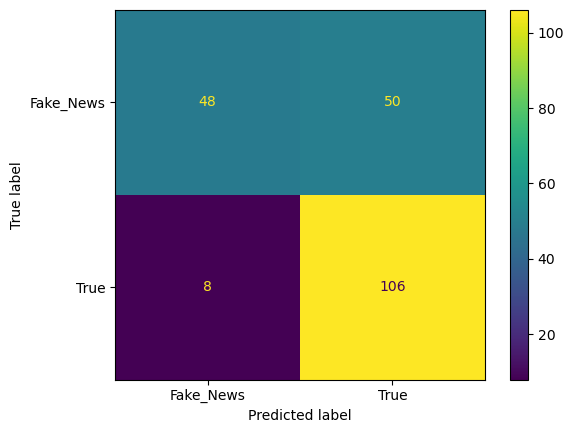

In [40]:
cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=["Fake_News", True])
cm_display1.plot()
plt.show()

Naive Bayes Classifier

In [41]:
pp2 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',MultinomialNB())])

pp2.fit(X1_train, y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [42]:
predictions2 = pp2.predict(X1_test)

In [43]:
confusion_matrix2 = confusion_matrix(y1_test, predictions2)
print(confusion_matrix2)
print('\n')
print(classification_report(y1_test, predictions2))

[[ 57  41]
 [  8 106]]


              precision    recall  f1-score   support

           0       0.88      0.58      0.70        98
           1       0.72      0.93      0.81       114

    accuracy                           0.77       212
   macro avg       0.80      0.76      0.76       212
weighted avg       0.79      0.77      0.76       212



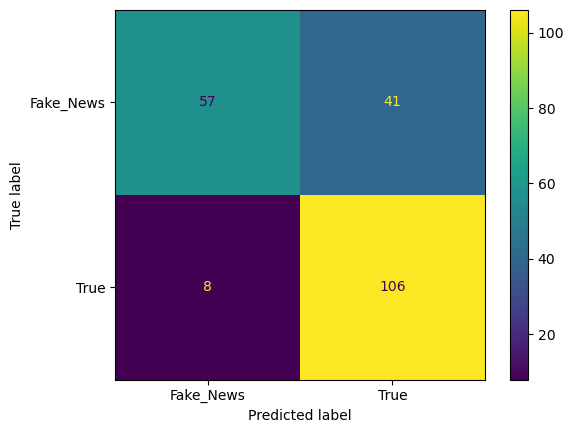

In [44]:
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix2, display_labels=["Fake_News", True])
cm_display2.plot()
plt.show()

Passive Aggressive Classifier

In [45]:
pp3 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',PassiveAggressiveClassifier())])

pp3.fit(X1_train, y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [46]:
predictions3 = pp3.predict(X1_test)

In [47]:
confusion_matrix3 = confusion_matrix(y1_test, predictions3)
print(confusion_matrix3)
print('\n')
print(classification_report(y1_test, predictions3))

[[ 78  20]
 [ 12 102]]


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        98
           1       0.84      0.89      0.86       114

    accuracy                           0.85       212
   macro avg       0.85      0.85      0.85       212
weighted avg       0.85      0.85      0.85       212



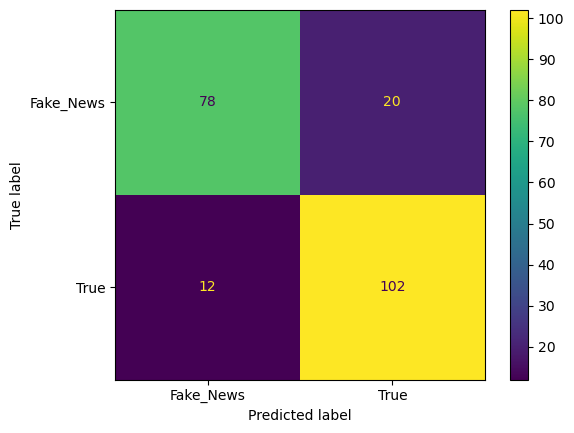

In [48]:
cm_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix3, display_labels=["Fake_News", True])
cm_display3.plot()
plt.show()

Consider now the entire dataset, composed by politifact dataset and gossipcop dataset.

In [49]:
display(dataset)

,id,news_url,title,tweet_ids,verdict
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...
23191,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1
23192,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1
23193,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1
23194,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1


In [52]:
X2=dataset['title']
y2=dataset['verdict']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

Random Forest Classifier

In [53]:
pp4 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',RandomForestClassifier())])

pp4.fit(X2_train, y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [54]:
predictions4 = pp4.predict(X2_test)

In [55]:
confusion_matrix4 = confusion_matrix(y2_test, predictions4)
print(confusion_matrix4)
print('\n')
print(classification_report(y2_test, predictions4))

[[ 576  590]
 [ 160 3314]]


              precision    recall  f1-score   support

           0       0.78      0.49      0.61      1166
           1       0.85      0.95      0.90      3474

    accuracy                           0.84      4640
   macro avg       0.82      0.72      0.75      4640
weighted avg       0.83      0.84      0.82      4640



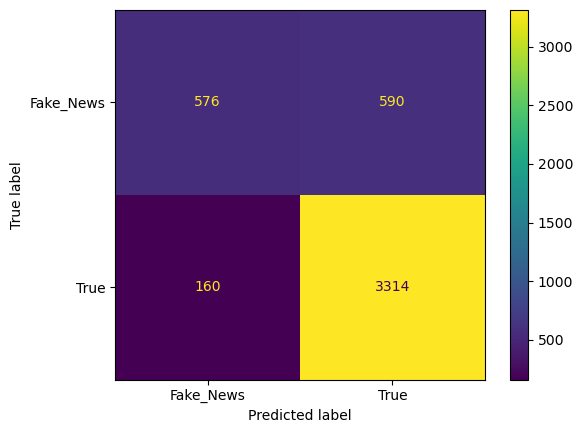

In [56]:
cm_display4 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix4, display_labels=["Fake_News", True])
cm_display4.plot()
plt.show()

Naive Bayes Classifier

In [57]:
pp5 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',MultinomialNB())])

pp5.fit(X2_train, y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [58]:
predictions5 = pp5.predict(X2_test)

In [59]:
confusion_matrix5 = confusion_matrix(y2_test, predictions5)
print(confusion_matrix5)
print('\n')
print(classification_report(y2_test, predictions5))

[[ 366  800]
 [  43 3431]]


              precision    recall  f1-score   support

           0       0.89      0.31      0.46      1166
           1       0.81      0.99      0.89      3474

    accuracy                           0.82      4640
   macro avg       0.85      0.65      0.68      4640
weighted avg       0.83      0.82      0.78      4640



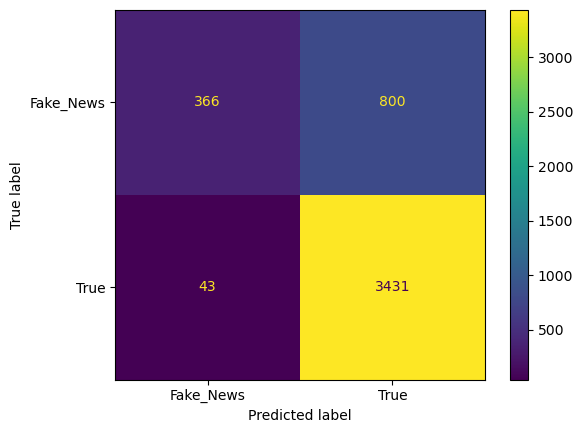

In [60]:
cm_display5 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix5, display_labels=["Fake_News", True])
cm_display5.plot()
plt.show()

Passive Aggressive Classifier

In [61]:
pp6 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',PassiveAggressiveClassifier())])

pp6.fit(X2_train, y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [62]:
predictions6 = pp6.predict(X2_test)

In [63]:
confusion_matrix6 = confusion_matrix(y2_test, predictions6)
print(confusion_matrix6)
print('\n')
print(classification_report(y2_test, predictions6))

[[ 726  440]
 [ 528 2946]]


              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1166
           1       0.87      0.85      0.86      3474

    accuracy                           0.79      4640
   macro avg       0.72      0.74      0.73      4640
weighted avg       0.80      0.79      0.79      4640



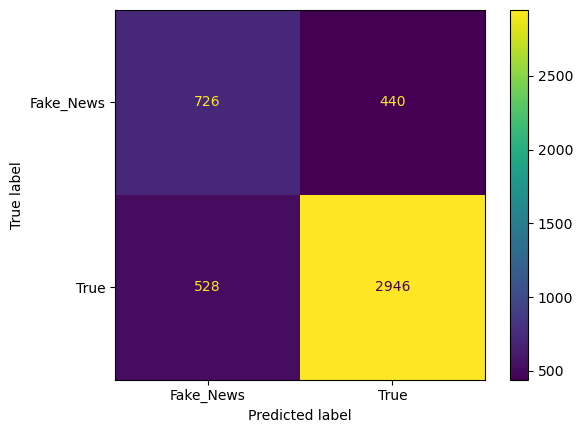

In [64]:
cm_display6 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix6, display_labels=["Fake_News", True])
cm_display6.plot()
plt.show()

Now we repeat the classification task adding to the input also the centralities values found from the graph analysis: the closeness centrality and the pagerank.

In [65]:
# Add the columns with centralities
nodes_closeness_centrality = nx.closeness_centrality(G1)
print(nodes_closeness_centrality)

{'politifact15014': 0.0, 'politifact15156': 0.0, 'politifact14745': 0.0, 'politifact14355': 0.0, 'politifact15371': 0.0, 'politifact14404': 0.0, 'politifact13919': 0.0, 'politifact14795': 0.0, 'politifact14328': 0.0, 'politifact13775': 0.0, 'politifact14678': 0.0, 'politifact14394': 0.0, 'politifact14376': 0.0, 'politifact14233': 0.0, 'politifact14890': 0.0, 'politifact14356': 0.0, 'politifact14776': 0.0, 'politifact15355': 0.0, 'politifact14664': 0.0, 'politifact15178': 0.0, 'politifact15052': 0.0, 'politifact15309': 0.0, 'politifact15267': 0.0, 'politifact13836': 0.0, 'politifact15553': 0.0, 'politifact14755': 0.0, 'politifact13806': 0.0, 'politifact15164': 0.0, 'politifact14388': 0.0, 'politifact14742': 0.0037529850632126763, 'politifact14544': 0.0, 'politifact13677': 0.0, 'politifact15280': 0.0, 'politifact14310': 0.0, 'politifact15130': 0.0, 'politifact14694': 0.0, 'politifact14863': 0.0, 'politifact15004': 0.0, 'politifact13773': 0.0, 'politifact14258': 0.0, 'politifact14235': 0.

In [66]:
fakeNewsDataset = dataset
#fakeNewsDataset.insert(len(fakeNewsDataset.columns), "Closeness", nodes_closeness_centrality)
fakeNewsDataset['Closeness'] = fakeNewsDataset['id'].map(nodes_closeness_centrality)
display(fakeNewsDataset)

,id,news_url,title,tweet_ids,verdict,Closeness
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0,0.0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0,0.0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0,0.0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0,0.0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0,0.0
...,...,...,...,...,...,...
23191,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1,0.0
23192,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1,0.0
23193,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1,0.0
23194,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1,0.0


In [67]:
fakeNewsDataset['title_closeness'] = fakeNewsDataset['title'] + ': ' + str(fakeNewsDataset['Closeness'])
X3=fakeNewsDataset['title_closeness']
y3=fakeNewsDataset['verdict']


X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

Random Forest Classifier

In [68]:
pp7 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',RandomForestClassifier())])

pp7.fit(X3_train, y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [69]:
predictions7 = pp7.predict(X3_test)

In [70]:
confusion_matrix7 = confusion_matrix(y3_test, predictions7)
print(confusion_matrix7)
print('\n')
print(classification_report(y3_test, predictions7))

[[ 491  675]
 [ 127 3347]]


              precision    recall  f1-score   support

           0       0.79      0.42      0.55      1166
           1       0.83      0.96      0.89      3474

    accuracy                           0.83      4640
   macro avg       0.81      0.69      0.72      4640
weighted avg       0.82      0.83      0.81      4640



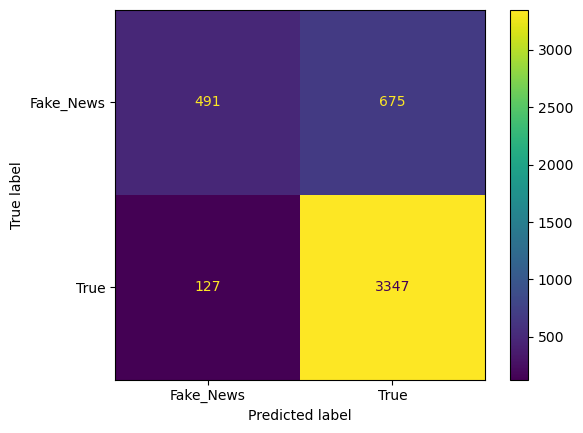

In [71]:
cm_display7 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix7, display_labels=["Fake_News", True])
cm_display7.plot()
plt.show()

Naive Bayes Classifier

In [72]:
pp8 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',MultinomialNB())])

pp8.fit(X3_train, y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [73]:
predictions8 = pp8.predict(X3_test)

In [74]:
confusion_matrix8 = confusion_matrix(y3_test, predictions8)
print(confusion_matrix8)
print('\n')
print(classification_report(y3_test, predictions8))

[[ 326  840]
 [  39 3435]]


              precision    recall  f1-score   support

           0       0.89      0.28      0.43      1166
           1       0.80      0.99      0.89      3474

    accuracy                           0.81      4640
   macro avg       0.85      0.63      0.66      4640
weighted avg       0.83      0.81      0.77      4640



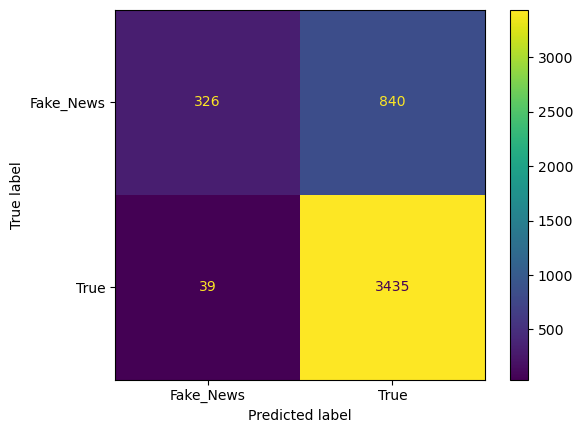

In [75]:
cm_display8 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix8, display_labels=["Fake_News", True])
cm_display8.plot()
plt.show()

Passive Aggressive Classifier

In [76]:
pp9 = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('classifier',PassiveAggressiveClassifier())])

pp9.fit(X3_train, y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [77]:
predictions9 = pp9.predict(X3_test)

In [78]:
confusion_matrix9 = confusion_matrix(y3_test, predictions9)
print(confusion_matrix9)
print('\n')
print(classification_report(y3_test, predictions9))

[[ 735  431]
 [ 534 2940]]


              precision    recall  f1-score   support

           0       0.58      0.63      0.60      1166
           1       0.87      0.85      0.86      3474

    accuracy                           0.79      4640
   macro avg       0.73      0.74      0.73      4640
weighted avg       0.80      0.79      0.79      4640



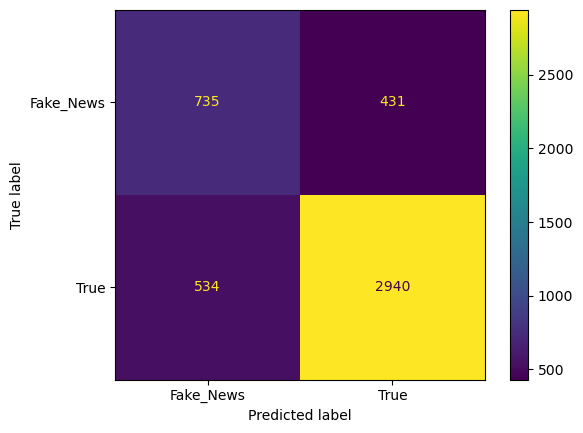

In [79]:
cm_display9 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix9, display_labels=["Fake_News", True])
cm_display9.plot()
plt.show()

<h1>NODE EMBEDDINGS</h1>

We decided to add another analysis of the network of news to understand if exploiting some characteristics of the graph topology would 
enhance the classification task. 
So, to be able to use such information, we decided to perform the node embedding of the graph created using the first definition but using the titles instead of the articles ids.
Using the resulting embeddings as a training set, we repeated the classification task.

To perform node embeddings, we select the "Node2Vec" framework, that fits well with the node binary classification we want to perform.

Node2Vec useful references: 
<ul>
    <li> https://github.com/eliorc/node2vec.git</li>
    <li>A. Grover and J. Leskovec, “Node2vec: Scalable feature learning for networks,” in KDD, 2016, pp. 855–864</li>
</ul>

In [80]:
articles_dict = {}

# iterate through all articles in the dataset
for i in range(len(dataset['title'])):
    # check if the corresponding tweet list for the article is not empty (dataFrame sets an empty list as NaN)
    if (not pd.isna(dataset.at[i, 'tweet_ids'])):
      # if a list exists, join all its elements as a single string (where all ids will be separated by " ")
      string_ids = ''.join(dataset.at[i, 'tweet_ids'])
      # create a key value pair of the kind [article_id, [list of tweets_ids]]
      articles_dict[dataset.at[i, 'title']] = string_ids.split()

G1 = nx.Graph()

# this adds all nodes regardless of the tweets that have shared them
for i in range(len(dataset['title'])):
  G1.add_node(dataset['title'][i])

# convert the keys in a list so that you can index it to greatly reduce the number of comparisions
keys_list = list(articles_dict.keys())

for i in range(0, len(keys_list) - 1):
  for j in range(i + 1, len(keys_list)):
    if len(set(articles_dict[keys_list[i]]).intersection(set(articles_dict[keys_list[j]]))) > 0:
       G1.add_edge(keys_list[i], keys_list[j])

In [ ]:
X1 = dataset["title"]
y1 = dataset["verdict"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
print(y1_train)

Several parameters are available in order to tune the node embeddings. Some of them are:
<lu>
    <li>"dimension": dimension of the features vector that will be assign to each node</li>
    <li>"walk_length": length of the random walks performed by the node2Vec algorithm</li>
    <li>"num_walks": number of random per node walks perfomed in order to compute the embeddings for each node</li>
</lu>

In [83]:
# pre-compute the probabilities and generate walks
node2vec = Node2Vec(G1, dimensions=64, walk_length=30, num_walks=200, workers=1)

# train the model for the nodes enbeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/21724 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


In [ ]:
#Print the embedding of a node :
model.wv.get_vector('Did Miley Cyrus and Liam Hemsworth secretly get married?')

In [ ]:
#Creation of the new Training set

X_train_emb=[] #training set composed by the train node embeddings
Y_train_emb=y1_train

for id in X1_train:
    X_train_emb.append(model.wv.get_vector(id))

X_train_emb=np.array(X_train_emb)
Y_train_emb=np.array(Y_train_emb)
    


In [ ]:
#Creation of the new Test set
X_test_emb=[] #training set composed by the train node embeddings
Y_test_emb=y1_test

for id in X1_test:
    X_test_emb.append(model.wv.get_vector(id))

X_test_emb=np.array(X_test_emb)
Y_test_emb=np.array(Y_test_emb)
    


<h3>Classification results using Nodes embeddings:</h3>

Random Forest Classifier:


In [88]:

rf=RandomForestClassifier()
rf_model = rf.fit(X_train_emb, Y_train_emb)

In [89]:
# Use the trained model to make predictions on the test data
y_pred_rf=rf_model.predict(X_test_emb)

In [90]:
confusion_matrix_rf = confusion_matrix(Y_test_emb, y_pred_rf)
print(confusion_matrix_rf)
print('\n')
print("Random Forest Classifier:")
print(classification_report(Y_test_emb, y_pred_rf))

[[ 232  934]
 [  32 3442]]


Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.88      0.20      0.32      1166
           1       0.79      0.99      0.88      3474

    accuracy                           0.79      4640
   macro avg       0.83      0.59      0.60      4640
weighted avg       0.81      0.79      0.74      4640



Random Forest Classifier:


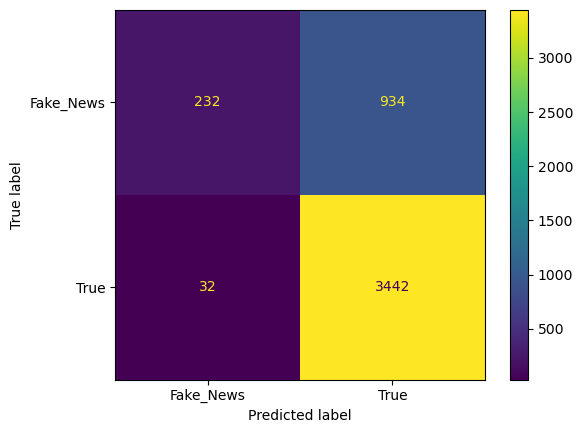

In [91]:
cm_display_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=["Fake_News", True])
print("Random Forest Classifier:")
cm_display_rf.plot()
plt.show()

 Naive Bayes Classifier:

In [92]:


#in order to remove negative values that are not accepted by  MultinomialNB
scaler = MinMaxScaler()
X_train_emb_scale = scaler.fit_transform(X_train_emb)
X_test_emb_scale = scaler.transform(X_test_emb)

In [93]:
nb = MultinomialNB()
nb_model=nb.fit(X_train_emb_scale, Y_train_emb)

In [94]:
# Use the trained model to make predictions on the test data
y_pred_nb=nb_model.predict(X_test_emb_scale)

In [95]:
confusion_matrix_nb = confusion_matrix(Y_test_emb, y_pred_nb)
print(confusion_matrix_nb)
print('\n')
print("Naive Bayes Classifier:")
print(classification_report(Y_test_emb, y_pred_nb))

[[  74 1092]
 [  60 3414]]


Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.55      0.06      0.11      1166
           1       0.76      0.98      0.86      3474

    accuracy                           0.75      4640
   macro avg       0.65      0.52      0.48      4640
weighted avg       0.71      0.75      0.67      4640



Naive Bayes Classifier:


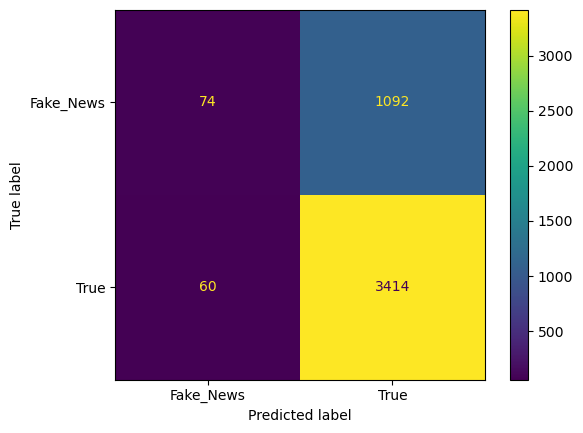

In [96]:
cm_display_nb = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nb, display_labels=["Fake_News", True])
print("Naive Bayes Classifier:")
cm_display_nb.plot()
plt.show()


Passive Aggressive Classifier:


In [97]:

pa=PassiveAggressiveClassifier()
pa_model=pa.fit(X_train_emb,Y_train_emb)

In [98]:
# Use the trained model to make predictions on the test data
y_pred_pa=pa_model.predict(X_test_emb)

In [99]:
confusion_matrix_pa = confusion_matrix(Y_test_emb, y_pred_pa)
print(confusion_matrix_pa)
print('\n')
print("Passive Aggressive Classifier:")
print(classification_report(Y_test_emb, y_pred_pa))

[[ 109 1057]
 [  37 3437]]


Passive Aggressive Classifier:
              precision    recall  f1-score   support

           0       0.75      0.09      0.17      1166
           1       0.76      0.99      0.86      3474

    accuracy                           0.76      4640
   macro avg       0.76      0.54      0.51      4640
weighted avg       0.76      0.76      0.69      4640



Passive Aggressive Classifier:


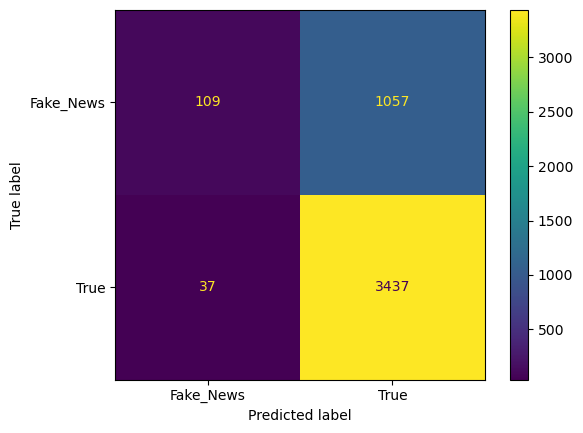

In [100]:
cm_display_pa = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_pa, display_labels=["Fake_News", True])
print("Passive Aggressive Classifier:")
cm_display_pa.plot()
plt.show()